# Are Severity Scores Biased?

Questions? Irene  Chen (iychen@mit.edu), 3/3/17

Inspired by the [Propublica investigation](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) of bias in predictive algorithms used in criminal justice, this notebook aims to explore whether bias exists in the mortality scores commonly used in ICUs.  

Requirements:

* MIMIC-III in a PostgreSQL database
* Severity scores calculated according to [mimic-code](https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores)
* Python packages installable with: 
    * `pip install numpy pandas matplotlib psycopg2 jupyter`
    
First, as always, we open a connection to a local copy of the database. If you don't have a local copy of the database in PostgreSQL, follow the tutorial online (http://mimic.physionet.org) to install one.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os
import scipy as sp

from scipy.stats import zscore
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LinearRegression as LinR

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mutual_info_score

from calcAUCVAR import calcAUCVAR

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'irenechen'
dbname = 'mimic'
schema_name = 'mimiciii'

datadir = '/Users/irenechen/Documents/mimic-data'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

# hide warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# import maggie's adult ICU stuff

df = pd.read_csv(os.path.join(datadir, 'adult_icu_nullinfo.gz'))

# select all severity score info

query = query_schema + """
SELECT 
    os.subject_id, os.hadm_id, os.icustay_id, oasis, sofa, saps, sapsii, apsiii, lods
FROM
oasis os
INNER JOIN sofa sf
on os.hadm_id = sf.hadm_id and os.subject_id = sf.subject_id and os.icustay_id = sf.icustay_id
INNER JOIN saps sp
on os.hadm_id = sp.hadm_id and os.subject_id = sp.subject_id and os.icustay_id = sp.icustay_id
INNER JOIN sapsii spii
on os.hadm_id = spii.hadm_id and os.subject_id = spii.subject_id and os.icustay_id = spii.icustay_id
INNER JOIN apsiii apsiii
on os.hadm_id = apsiii.hadm_id and os.subject_id = apsiii.subject_id and os.icustay_id = apsiii.icustay_id
INNER JOIN lods lods
on os.hadm_id = lods.hadm_id and os.subject_id = lods.subject_id and os.icustay_id = lods.icustay_id;
"""
sev_df = pd.read_sql_query(query, con)
sev_df.head()

mort_df = df.merge(sev_df,how = 'left',    on = ['subject_id', 'hadm_id', 'icustay_id'])

def eth(s):
  if s['eth_asian']:
    return 'asian'
  elif s['eth_black']:
    return 'black'
  elif s['eth_hispanic']:
    return 'hispanic'
  elif s['eth_white']:
    return 'white'
  else:
    return 'other'

mort_df['ethnicity'] = mort_df.apply(eth, axis=1)

In [3]:
print mort_df.columns
print len(mort_df.columns)

Index([u'subject_id', u'hadm_id', u'icustay_id', u'age', u'mort_hosp',
       u'mort_icu', u'mort_oneyr', u'first_hosp_stay', u'first_icu_stay',
       u'adult_icu', u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other',
       u'eth_white', u'admType_ELECTIVE', u'admType_EMERGENCY',
       u'admType_NEWBORN', u'admType_URGENT', u'heartrate_min',
       u'heartrate_max', u'heartrate_mean', u'sysbp_min', u'sysbp_max',
       u'sysbp_mean', u'diasbp_min', u'diasbp_max', u'diasbp_mean',
       u'meanbp_min', u'meanbp_max', u'meanbp_mean', u'resprate_min',
       u'resprate_max', u'resprate_mean', u'tempc_min', u'tempc_max',
       u'tempc_mean', u'spo2_min', u'spo2_max', u'spo2_mean', u'glucose_min',
       u'glucose_max', u'glucose_mean', u'aniongap', u'albumin',
       u'bicarbonate', u'bilirubin', u'creatinine', u'chloride', u'glucose',
       u'hematocrit', u'hemoglobin', u'lactate', u'magnesium', u'phosphate',
       u'platelet', u'potassium', u'ptt', u'inr', u'pt', u'sodium', u'

In [70]:
def eth(s):
  if s['eth_asian']:
    return 'asian'
  elif s['eth_black']:
    return 'black'
  elif s['eth_hispanic']:
    return 'hispanic'
  elif s['eth_white']:
    return 'white'
  else:
    return 'other'

mort_df['ethnicity'] = mort_df.apply(eth, axis=1)

Dataset: 27348 entries


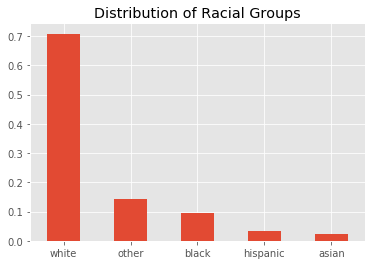

In [4]:
print 'Dataset: %d entries' % len(mort_df)

mort_df['ethnicity'].value_counts().apply(lambda x: x / float(len(mort_df))).plot('bar')
plt.xticks(rotation=0)
plt.title('Distribution of Racial Groups')
plt.show()

In [7]:
mort_df['ethnicity'].value_counts().apply(lambda x: x / float(len(mort_df)))

white       0.708059
other       0.142753
black       0.094376
hispanic    0.032214
asian       0.022598
Name: ethnicity, dtype: float64

# Predictive Parity

In [72]:
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

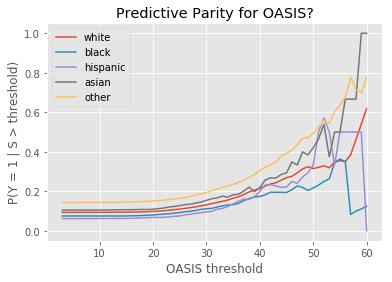

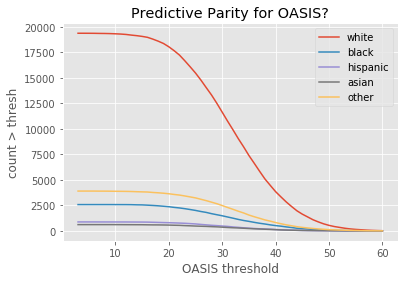

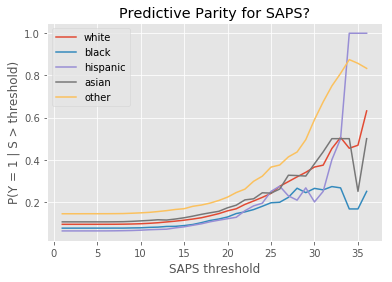

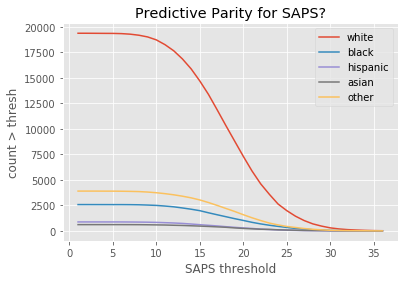

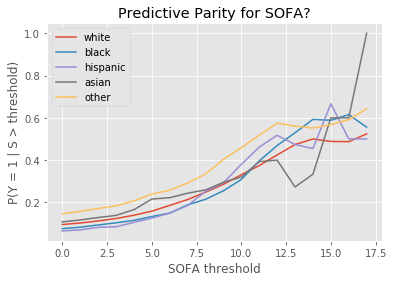

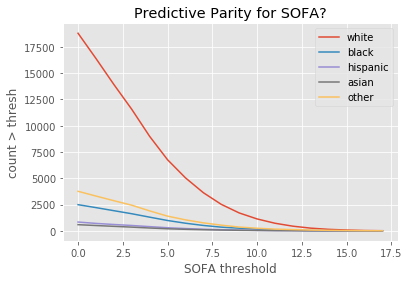

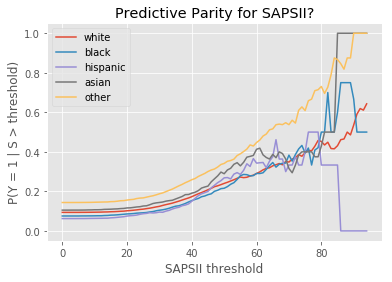

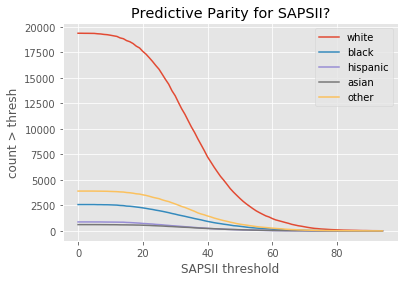

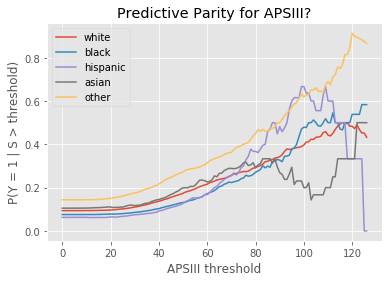

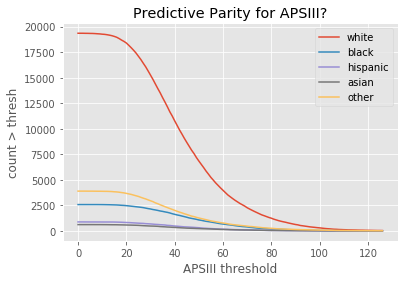

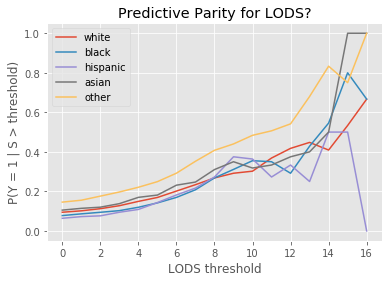

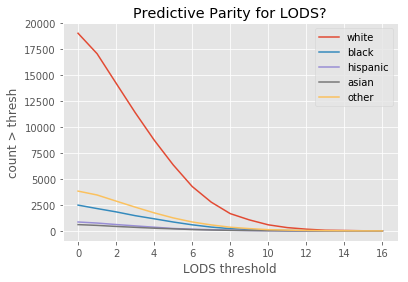

In [73]:
for ss in s_lst:
    saps_min = mort_df[ss].min()
    saps_max = mort_df[ss].max()

    r_lst = ['white', 'black', 'hispanic', 'asian', 'other']
    results = {r: list() for r in r_lst}
    counts = {r: list() for r in r_lst}
    thr_lst = list()

    for saps_thresh in xrange(saps_min, saps_max):
        mort_df['sev_bool'] = mort_df[ss].apply(lambda x: x > saps_thresh)
        df_slice = mort_df[mort_df['sev_bool']]
        sub_df = df_slice.groupby('ethnicity')['mort_icu'].mean()
        c_df = df_slice.groupby('ethnicity')['mort_icu'].count()
        if len(sub_df.index.values) == 5:
            for r in r_lst:
                results[r].append(sub_df.ix[r])
                counts[r].append(c_df.ix[r])
            thr_lst.append(saps_thresh)

    plt.figure()
    for r in r_lst:
        plt.plot(thr_lst, results[r], label=r)

    plt.title('Predictive Parity for %s?' % ss.upper())
    plt.xlabel('%s threshold' % ss.upper())
    plt.ylabel('P(Y = 1 | S > threshold)')
    plt.legend()
    plt.show()

    plt.figure()
    for r in r_lst:
        plt.plot(thr_lst, counts[r], label=r)

    plt.title('Predictive Parity for %s?' % ss.upper())
    plt.xlabel('%s threshold' % ss.upper())
    plt.ylabel('count > thresh')
    plt.legend()
    plt.show()


# Error Rate Balance

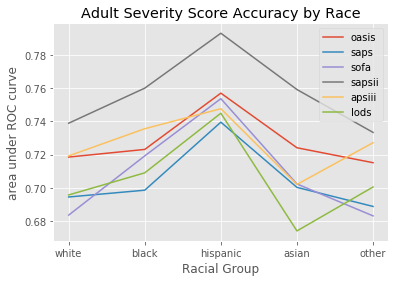

In [74]:
# Let's find the AUC for SAPS for each racial group

def get_auc(score, expire):
    fpr, tpr, thresholds = roc_curve(expire, score)
    return auc(fpr, tpr)

# df['icu_expire_bool'] = df['icustay_expire_flag'] == 'Y'

# HERE IT IS:  race
# target_df = mort_df[df['icustay_age_group'] == 'adult']
target_df = mort_df

sev_scores = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']
rlst = ['white', 'black', 'hispanic', 'asian', 'other']
ss = 'saps'
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

plt.figure()
for ss in s_lst:
    score_lst = list()
    for r in rlst:
        r_df = target_df[target_df['ethnicity'] == r]
        auc_score = get_auc(r_df[ss], r_df['mort_icu'])
        score_lst.append(auc_score)
    #         print '%s: %.4f' % (r, auc_score)
    #     print

    plt.plot(range(len(score_lst)), score_lst, label=ss)
    #     plt.title(ss)
    plt.xticks(range(len(score_lst)), rlst)
#     plt.ylim(min(s_lst)*0.9,max(s_lst) * 1.1)
plt.title('Adult Severity Score Accuracy by Race')
plt.xlabel('Racial Group')
plt.ylabel('area under ROC curve')
plt.legend()
plt.show()

In [75]:
# what is the AUC of these scores overall (not just by race)?
for ss in s_lst:
    auc_score = get_auc(mort_df[ss], mort_df['mort_icu'])
    print '%s: %.4f' % (ss, auc_score)

oasis: 0.7200
saps: 0.6952
sofa: 0.6876
sapsii: 0.7410
apsiii: 0.7184
lods: 0.6977


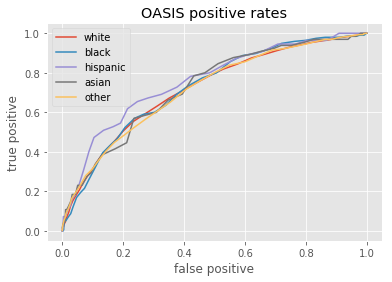

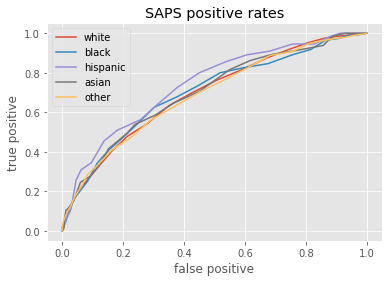

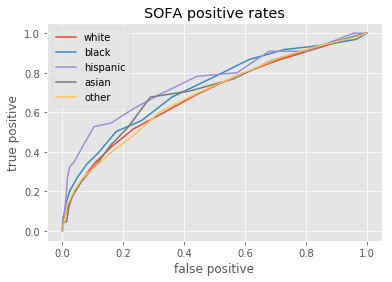

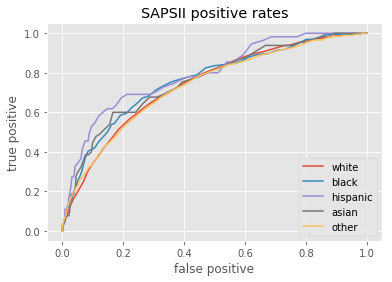

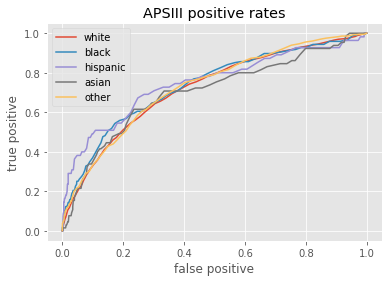

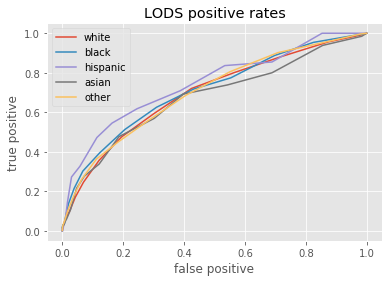

In [76]:
# let's do some cutoff stuff
eth = 'white'
gammas = list()
ss = 'saps'
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

for ss in s_lst:
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for eth in rlst:
    
        df_slice = mort_df[(mort_df['ethnicity'] == eth)]
        fpr, tpr, thresholds = roc_curve(df_slice['mort_icu'], df_slice[ss])
        plt.plot(fpr, tpr, label=eth)

    plt.legend()
    plt.title('%s positive rates' % ss.upper())
    plt.xlabel('false positive')
    plt.ylabel('true positive')
    plt.show()

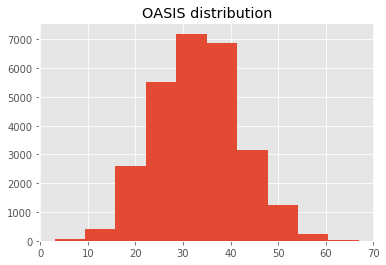

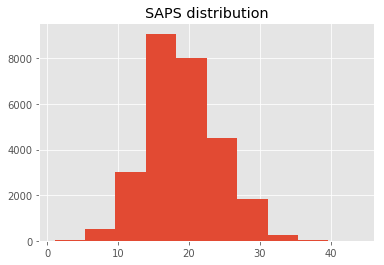

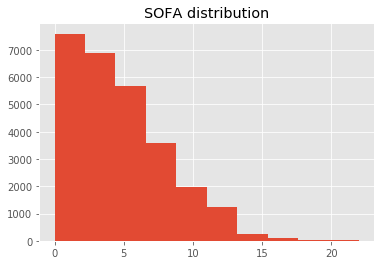

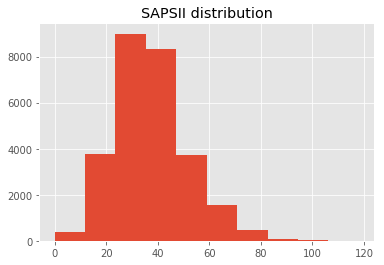

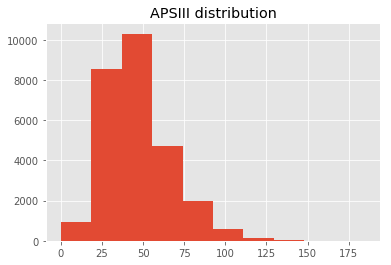

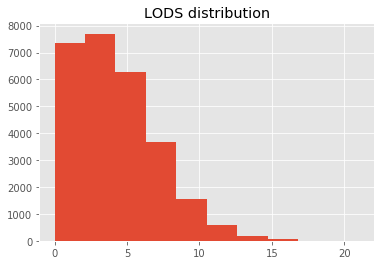

In [77]:
for ss in s_lst:
    plt.figure()
    mort_df[ss].hist()
    plt.title('%s distribution' % ss.upper())

## Conditional Mutual Information
In addition to ROC curve comparison, we can examine [conditional mutual information](https://en.wikipedia.org/wiki/Conditional_mutual_information) in order to show [equalized odds](https://arxiv.org/pdf/1610.02413v1.pdf)

In [78]:
# mort_df = df.merge(sev_df,how = 'left',    on = ['subject_id', 'hadm_id', 'icustay_id'])

print df.columns

Index([u'subject_id', u'hadm_id', u'icustay_id', u'age', u'mort_hosp',
       u'mort_icu', u'mort_oneyr', u'first_hosp_stay', u'first_icu_stay',
       u'adult_icu', u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other',
       u'eth_white', u'admType_ELECTIVE', u'admType_EMERGENCY',
       u'admType_NEWBORN', u'admType_URGENT', u'heartrate_min',
       u'heartrate_max', u'heartrate_mean', u'sysbp_min', u'sysbp_max',
       u'sysbp_mean', u'diasbp_min', u'diasbp_max', u'diasbp_mean',
       u'meanbp_min', u'meanbp_max', u'meanbp_mean', u'resprate_min',
       u'resprate_max', u'resprate_mean', u'tempc_min', u'tempc_max',
       u'tempc_mean', u'spo2_min', u'spo2_max', u'spo2_mean', u'glucose_min',
       u'glucose_max', u'glucose_mean', u'aniongap', u'albumin',
       u'bicarbonate', u'bilirubin', u'creatinine', u'chloride', u'glucose',
       u'hematocrit', u'hemoglobin', u'lactate', u'magnesium', u'phosphate',
       u'platelet', u'potassium', u'ptt', u'inr', u'pt', u'sodium', u'

In [79]:
# y = mort_icu, y_hat = sev score, a = race
y = 'mort_icu'
y_hat = 'saps'
a = 'eth_white'

# test = df[df[y]]

In [80]:
mort_df.columns

Index([u'subject_id', u'hadm_id', u'icustay_id', u'age', u'mort_hosp',
       u'mort_icu', u'mort_oneyr', u'first_hosp_stay', u'first_icu_stay',
       u'adult_icu', u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other',
       u'eth_white', u'admType_ELECTIVE', u'admType_EMERGENCY',
       u'admType_NEWBORN', u'admType_URGENT', u'heartrate_min',
       u'heartrate_max', u'heartrate_mean', u'sysbp_min', u'sysbp_max',
       u'sysbp_mean', u'diasbp_min', u'diasbp_max', u'diasbp_mean',
       u'meanbp_min', u'meanbp_max', u'meanbp_mean', u'resprate_min',
       u'resprate_max', u'resprate_mean', u'tempc_min', u'tempc_max',
       u'tempc_mean', u'spo2_min', u'spo2_max', u'spo2_mean', u'glucose_min',
       u'glucose_max', u'glucose_mean', u'aniongap', u'albumin',
       u'bicarbonate', u'bilirubin', u'creatinine', u'chloride', u'glucose',
       u'hematocrit', u'hemoglobin', u'lactate', u'magnesium', u'phosphate',
       u'platelet', u'potassium', u'ptt', u'inr', u'pt', u'sodium', u'

In [81]:
races = [u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other',
       u'eth_white']

y = 'mort_icu'
y_hat = 'saps'
a = 'eth_white'

for a in races:
    sub_df = mort_df[mort_df[a] == 0]
    print 'MI of %s: %.4f' % (a, mutual_info_score(sub_df[y], sub_df[y_hat]))

    sub_df = mort_df[mort_df[a] == 1]

    print 'MI of non-%s: %.4f' % (a, mutual_info_score(sub_df[y], sub_df[y_hat]))
    print

MI of eth_asian: 0.0242
MI of non-eth_asian: 0.0446

MI of eth_black: 0.0252
MI of non-eth_black: 0.0247

MI of eth_hispanic: 0.0242
MI of non-eth_hispanic: 0.0358

MI of eth_other: 0.0230
MI of non-eth_other: 0.0369

MI of eth_white: 0.0275
MI of non-eth_white: 0.0238



In [82]:
print len(df)

27348


In [83]:
# Demographic parity

races = [u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other',
       u'eth_white']
for i in races:
    print i
    print sum(mort_df[mort_df[i] == 0]['mort_icu']) / float(len(mort_df[mort_df[i] == 0]))
    print sum(mort_df[mort_df[i] == 1]['mort_icu']) / float(len(mort_df[mort_df[i] == 1]))
    print 

eth_asian
0.0982416760195
0.105177993528

eth_black
0.100779262729
0.0755521115847

eth_hispanic
0.0995957229758
0.0624290578888

eth_other
0.0908548029347
0.143698770492

eth_white
0.109719438878
0.0937306341665



In [ ]:
# Predictive parity using other threshold

s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

for ss in s_lst:
    saps_min = mort_df[ss].min()
    saps_max = mort_df[ss].max()

    r_lst = ['white', 'black', 'hispanic', 'asian', 'other']
    results = {r: list() for r in r_lst}
    counts = {r: list() for r in r_lst}
    thr_lst = list()

    for saps_thresh in xrange(saps_min, saps_max):
        mort_df['sev_bool'] = mort_df[ss].apply(lambda x: x < saps_thresh)
        df_slice = mort_df[mort_df['sev_bool']]
        sub_df = df_slice.groupby('ethnicity')['mort_icu'].mean()
        c_df = df_slice.groupby('ethnicity')['mort_icu'].count()
        if len(sub_df.index.values) == 5:
            for r in r_lst:
                results[r].append(sub_df.ix[r])
                counts[r].append(c_df.ix[r])
            thr_lst.append(saps_thresh)

    plt.figure()
    for r in r_lst:
        plt.plot(thr_lst, results[r], label=r)

    plt.title('Predictive Parity for %s?' % ss.upper())
    plt.xlabel('%s threshold' % ss.upper())
    plt.ylabel('P(Y = 1 | S < threshold)')
    plt.legend()
    plt.show()

    plt.figure()
    for r in r_lst:
        plt.plot(thr_lst, counts[r], label=r)

    plt.title('Predictive Parity for %s?' % ss.upper())
    plt.xlabel('%s threshold' % ss.upper())
    plt.ylabel('count > thresh')
    plt.legend()
    plt.show()

/Users/irenechen/Documents/venv/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


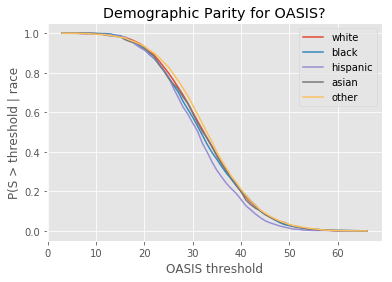

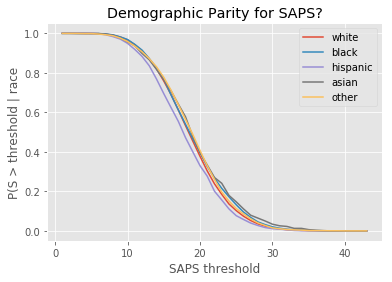

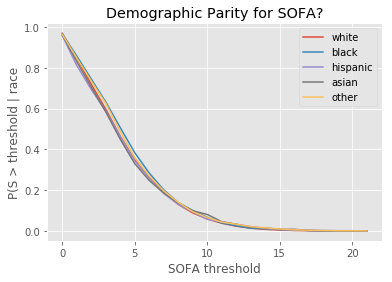

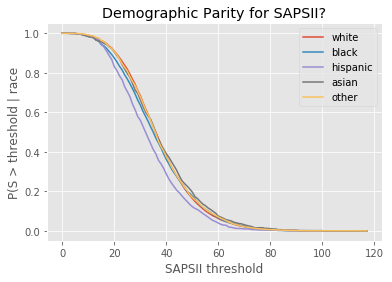

In [ ]:
# Demographic parity

s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

for ss in s_lst:
    saps_min = mort_df[ss].min()
    saps_max = mort_df[ss].max()

    r_lst = ['white', 'black', 'hispanic', 'asian', 'other']
    results = {r: list() for r in r_lst}
    counts = {r: list() for r in r_lst}
    thr_lst = list()

    for saps_thresh in xrange(saps_min, saps_max):
        if len(sub_df.index.values) == 5:
            for r in r_lst:
                df_slice = mort_df[mort_df['ethnicity'] == r]
                df_slice['sev_bool'] = df_slice[ss].apply(lambda x: x > saps_thresh)
                results[r].append(len(df_slice[df_slice['sev_bool']]) / float(len(df_slice)))
                counts[r].append(float(len(df_slice)))
            thr_lst.append(saps_thresh)

    plt.figure()
    for r in r_lst:
        plt.plot(thr_lst, results[r], label=r)

    plt.title('Demographic Parity for %s?' % ss.upper())
    plt.xlabel('%s threshold' % ss.upper())
    plt.ylabel('P(S > threshold | race')
    plt.legend()
    plt.show()


# Test for Null 

In [ ]:
test_df = pd.DataFrame(np.random.randn(10,6))
test_df.iloc[1:3,1] = np.nan
test_df.iloc[5,3] = np.nan
test_df.iloc[7:9,5] = np.nan

In [ ]:
test_df.isnull()

In [ ]:
# do any of the values in that row have null values?
test_df.isnull().any(axis=1)

# Confidence Interval for ROC Curves

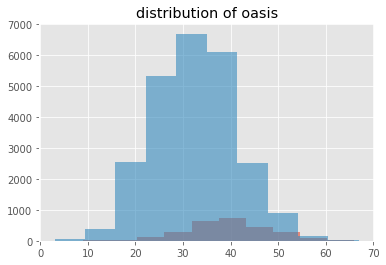

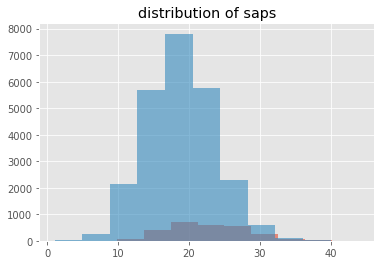

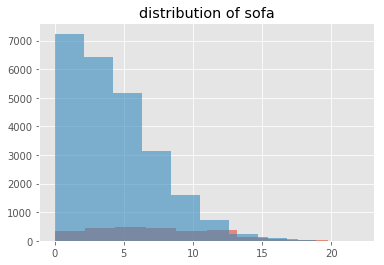

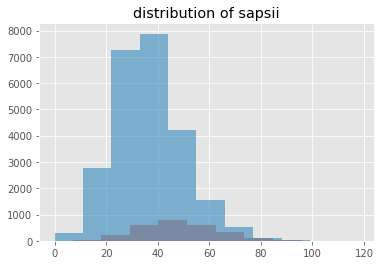

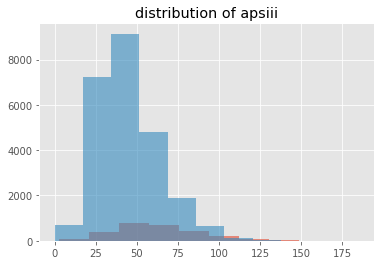

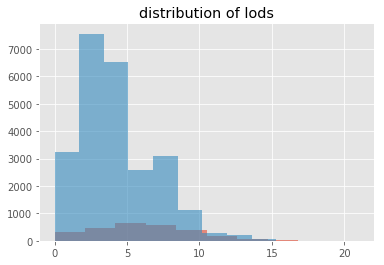

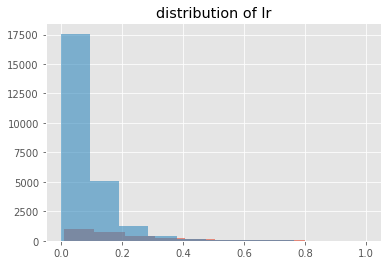

In [39]:
# are X (scores of positive examples) and Y (scores of negative examples) exponentially distributed? No!

for ss in s_lst:
    mort_df[mort_df['mort_icu'] == 1][ss].hist(alpha=0.6)
    mort_df[mort_df['mort_icu'] == 0][ss].hist(alpha=0.6)
#     mort_df[(mort_df[ss] == 1) & (mort_df['mort_icu'] == 1)].hist(alpha=0.6)
    plt.title('distribution of %s' % ss)
    plt.show()

In [42]:
# Let's find the AUC for SAPS for each racial group

def get_auc(score, expire):
    fpr, tpr, thresholds = roc_curve(expire, score)
    return auc(fpr, tpr)

# df['icu_expire_bool'] = df['icustay_expire_flag'] == 'Y'

# HERE IT IS:  race
# target_df = mort_df[df['icustay_age_group'] == 'adult']
target_df = mort_df

sev_scores = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']
rlst = ['white', 'black', 'hispanic', 'asian', 'other']
ss = 'saps'
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

for ss in s_lst:
    print ss
    score_lst = list()
    for r in rlst:
        r_df = target_df[target_df['ethnicity'] == r]
        auc_score = get_auc(r_df[ss], r_df['mort_icu'])
        
        X = list(r_df[r_df['mort_icu'] == 1][ss])
        Y = list(r_df[r_df['mort_icu'] == 0][ss])
        
        var = calcAUCVAR(X,Y,auc_score)
        
        print '%s: %.2f (+- %.5f)' %(r, auc_score,var * 1/np.sqrt(0.05))
        score_lst.append(auc_score)
    print
    #         print '%s: %.4f' % (r, auc_score)
    #     print

#     plt.plot(range(len(score_lst)), score_lst, label=ss)
    #     plt.title(ss)
#     plt.xticks(range(len(score_lst)), rlst)
#     plt.ylim(min(s_lst)*0.9,max(s_lst) * 1.1)
# plt.title('Adult Severity Score Accuracy by Race')
# plt.xlabel('Racial Group')
# plt.ylabel('area under ROC curve')
# plt.legend()
# plt.show()

oasis
white: 0.72 (+- 0.00018)
black: 0.72 (+- 0.00145)
hispanic: 0.76 (+- 0.00525)
asian: 0.72 (+- 0.00468)
other: 0.72 (+- 0.00060)

saps
white: 0.69 (+- 0.00018)
black: 0.70 (+- 0.00182)
hispanic: 0.74 (+- 0.00527)
asian: 0.70 (+- 0.00538)
other: 0.69 (+- 0.00066)

sofa
white: 0.68 (+- 0.00022)
black: 0.72 (+- 0.00184)
hispanic: 0.75 (+- 0.00685)
asian: 0.70 (+- 0.00604)
other: 0.68 (+- 0.00072)

sapsii
white: 0.74 (+- 0.00016)
black: 0.76 (+- 0.00150)
hispanic: 0.79 (+- 0.00453)
asian: 0.76 (+- 0.00462)
other: 0.73 (+- 0.00059)

apsiii
white: 0.72 (+- 0.00019)
black: 0.74 (+- 0.00175)
hispanic: 0.75 (+- 0.00729)
asian: 0.70 (+- 0.00634)
other: 0.73 (+- 0.00059)

lods
white: 0.70 (+- 0.00020)
black: 0.71 (+- 0.00183)
hispanic: 0.74 (+- 0.00606)
asian: 0.67 (+- 0.00664)
other: 0.70 (+- 0.00065)



In [ ]:
fig, ax = plt.subplots()


In [41]:
# testing out calcAUCVAR
X = list(r_df[r_df['mort_icu'] == 1][ss])
Y = list(r_df[r_df['mort_icu'] == 0][ss])

auc_score = get_auc(r_df[ss], r_df['mort_icu'])
calcAUCVAR(X,Y,auc_score)

0.00014557768768192687

In [ ]:
fpr, tpr, thresholds = roc_curve(r_df['mort_icu'],r_df[ss])

# Bring on the Logistic Regression

In [17]:
excl_col = set(['subject_id', 'hadm_id', 'icustay_id', 'mort_oneyr', 'mort_hosp',
                'adult_icu', 'train', 'mort_icu', 'had_null'])
target_col = 'mort_icu'

feature_col = [i for i in df.columns if i not in excl_col]

In [18]:
adult_df = df

# is_train = adult_df['train'] == 1
# is_test = adult_df['train'] == 0

X = adult_df[feature_col]
Y = adult_df[target_col]

# X_train = adult_df[is_train][feature_col]
# y_train = adult_df[is_train][target_col]

# X_test = adult_df[is_test][feature_col]
# y_test = adult_df[is_test][target_col]

logreg = LR()
logreg.fit(X, Y)

coef_vars = sorted(zip((logreg.coef_[0]), feature_col)) 

# What are the top five and bottom five predictors?
print 'TOP 5 HIGHEST'

for i,j in coef_vars[-1:-6:-1]:
    print '%s: %.4f' % (j,i)

print 
    
print 'TOP 5 LOWEST'
for i,j in coef_vars[:5]:
    print '%s: %.4f' % (j,i)

TOP 5 HIGHEST
lactate: 0.1080
admType_EMERGENCY: 0.0761
resprate_mean: 0.0727
eth_other: 0.0694
bilirubin: 0.0565

TOP 5 LOWEST
tempc_min: -0.1216
albumin: -0.0928
admType_ELECTIVE: -0.0780
creatinine: -0.0778
hemoglobin: -0.0485


In [19]:
def get_auc(score, expire):
    fpr, tpr, thresholds = roc_curve(expire, score)
    return auc(fpr, tpr)

y_prob = logreg.predict_proba(X)

# y_prob = logreg.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

print 'LR AUC: %.4f' % get_auc(y_prob[:,1], Y)

LR AUC: 0.7709


In [20]:
# add LR to scores of y_prob
mort_df['lr'] = y_prob[:,1]

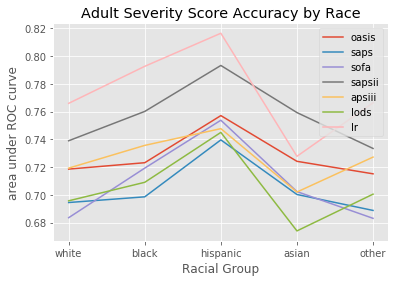

In [21]:
# REDO ERROR RATE BALANCE INCLUDING LR

# add LR to scores of y_prob
mort_df['lr'] = y_prob[:,1]

def get_auc(score, expire):
    fpr, tpr, thresholds = roc_curve(expire, score)
    return auc(fpr, tpr)

# df['icu_expire_bool'] = df['icustay_expire_flag'] == 'Y'

# HERE IT IS:  race
# target_df = mort_df[df['icustay_age_group'] == 'adult']
target_df = mort_df

sev_scores = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']
rlst = ['white', 'black', 'hispanic', 'asian', 'other']
ss = 'saps'
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']

plt.figure()
for ss in s_lst:
    score_lst = list()
    for r in rlst:
        r_df = target_df[target_df['ethnicity'] == r]
        auc_score = get_auc(r_df[ss], r_df['mort_icu'])
        score_lst.append(auc_score)
    #         print '%s: %.4f' % (r, auc_score)
    #     print

    plt.plot(range(len(score_lst)), score_lst, label=ss)
    #     plt.title(ss)
    plt.xticks(range(len(score_lst)), rlst)
#     plt.ylim(min(s_lst)*0.9,max(s_lst) * 1.1)
plt.title('Adult Severity Score Accuracy by Race')
plt.xlabel('Racial Group')
plt.ylabel('area under ROC curve')
plt.legend()
plt.show()

Num patients w/o missing data: 8555


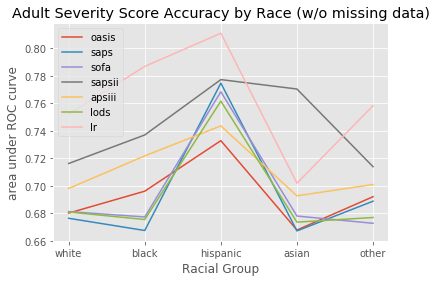

Num patients w/ missing data: 18793


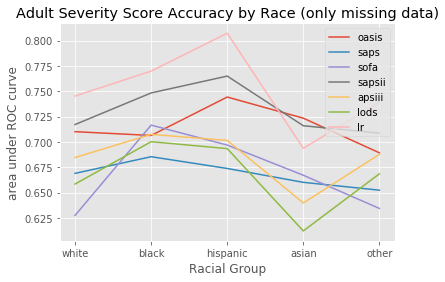

In [22]:
# now run without patients w/ missing data

target_df = mort_df[~mort_df['had_null']]
print 'Num patients w/o missing data: %d' % len(target_df)

sev_scores = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']
rlst = ['white', 'black', 'hispanic', 'asian', 'other']
ss = 'saps'
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']

plt.figure()
for ss in s_lst:
    score_lst = list()
    for r in rlst:
        r_df = target_df[target_df['ethnicity'] == r]
        auc_score = get_auc(r_df[ss], r_df['mort_icu'])
        score_lst.append(auc_score)
    #         print '%s: %.4f' % (r, auc_score)
    #     print

    plt.plot(range(len(score_lst)), score_lst, label=ss)
    #     plt.title(ss)
    plt.xticks(range(len(score_lst)), rlst)
#     plt.ylim(min(s_lst)*0.9,max(s_lst) * 1.1)
plt.title('Adult Severity Score Accuracy by Race (w/o missing data)')
plt.xlabel('Racial Group')
plt.ylabel('area under ROC curve')
plt.legend()
plt.show()

# now run without patients w/ missing data

target_df = mort_df[mort_df['had_null']]
print 'Num patients w/ missing data: %d' % len(target_df)

sev_scores = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']
rlst = ['white', 'black', 'hispanic', 'asian', 'other']
ss = 'saps'
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']

plt.figure()
for ss in s_lst:
    score_lst = list()
    for r in rlst:
        r_df = target_df[target_df['ethnicity'] == r]
        auc_score = get_auc(r_df[ss], r_df['mort_icu'])
        score_lst.append(auc_score)
    #         print '%s: %.4f' % (r, auc_score)
    #     print

    plt.plot(range(len(score_lst)), score_lst, label=ss)
    #     plt.title(ss)
    plt.xticks(range(len(score_lst)), rlst)
#     plt.ylim(min(s_lst)*0.9,max(s_lst) * 1.1)
plt.title('Adult Severity Score Accuracy by Race (only missing data)')
plt.xlabel('Racial Group')
plt.ylabel('area under ROC curve')
plt.legend()
plt.show()

# ICD9 Groupings

In [23]:
small = pd.read_csv(os.path.join(datadir, 'adult_icu_nullinfo_diag_small.gz'))
big = pd.read_csv(os.path.join(datadir, 'adult_icu_nullinfo_diag_big.gz'))
print len(big)
print len(small)

print 

print small.columns
print big.columns

big['ethnicity'] = mort_df.apply(eth, axis=1)

373658
27349

Index([u'subject_id', u'hadm_id', u'icustay_id', u'age', u'mort_hosp',
       u'mort_icu', u'mort_oneyr', u'first_hosp_stay', u'first_icu_stay',
       u'adult_icu', u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other',
       u'eth_white', u'admType_ELECTIVE', u'admType_EMERGENCY',
       u'admType_NEWBORN', u'admType_URGENT', u'had_null'],
      dtype='object')
Index([u'subject_id', u'hadm_id', u'icustay_id', u'gender', u'age',
       u'mort_hosp', u'mort_icu', u'mort_oneyr', u'first_hosp_stay',
       u'first_icu_stay', u'icd9_code', u'seq_icd9', u'adult_icu',
       u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other', u'eth_white',
       u'admType_ELECTIVE', u'admType_EMERGENCY', u'admType_NEWBORN',
       u'admType_URGENT', u'age_group', u'had_null'],
      dtype='object')


In [24]:
# check lens match

print len(np.unique(big['subject_id']))
print len(np.unique(big['hadm_id']))
print len(np.unique(big['icustay_id']))

print 

print len(np.unique(small['subject_id']))
print len(np.unique(small['hadm_id']))
print len(np.unique(small['icustay_id']))

21377
25810
27349

21377
25810
27349


In [25]:
# check that all elements in one are in the other

small_set = set(np.unique(small['hadm_id']))
big_set = set(np.unique(big['hadm_id']))

for i in np.unique(big['hadm_id']):
    if i not in small_set:
        print i

for i in np.unique(small['hadm_id']):
    if i not in big_set:
        print i

In [26]:
# read and parse groupings
# fpath = os.path.join(datadir, 'hcc_icd9_groups_with_headers.txt')
fpath = os.path.join(datadir, 'icd9_grp_file.txt')
f = open(fpath)
data = f.readlines()

In [27]:
icd9_d = dict()
group_d = dict()

group_c = 1
icd_c = 0

for num, line in enumerate(data):
    if line[0] != '"':
        raw_info = line.split('#')
        codes = map(lambda x: x.replace('.', ''), raw_info[0].split())
        label = raw_info[1]
        
        group_d[group_c] = label
    
        for c in codes:
            if c in icd9_d:
                print '%s already here! (line %d)' % (c, num)
            icd9_d[c] = group_c
            icd_c += 1
    else:
        disgard = line.split('FY2013')
        raw_info = disgard[1].split('#')
        codes = map(lambda x: x.replace('.', ''), raw_info[0].split())
        label = raw_info[1]
        group_d[group_c] = label
    
        for c in codes:
            if c in icd9_d:
                print '%s already here! (line %d)' % (c, num)
            icd9_d[c] = group_c
            icd_c += 1
    group_c += 1

V232 already here! (line 182)
V233 already here! (line 182)
V234 already here! (line 182)
V2341 already here! (line 182)
V2349 already here! (line 182)
V235 already here! (line 182)
V237 already here! (line 182)
V238 already here! (line 182)
V2381 already here! (line 182)
V2382 already here! (line 182)


In [28]:
print icd_c
print group_c

15082
284


In [29]:
big['dummy'] = 1

In [30]:
big['icd_gr'] = big['icd9_code'].apply(lambda x: icd9_d.get(x,None))
big['icd_gr_name'] = big['icd_gr'].apply(lambda x: group_d.get(x,None))

In [31]:
big.columns

Index([u'subject_id', u'hadm_id', u'icustay_id', u'gender', u'age',
       u'mort_hosp', u'mort_icu', u'mort_oneyr', u'first_hosp_stay',
       u'first_icu_stay', u'icd9_code', u'seq_icd9', u'adult_icu',
       u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other', u'eth_white',
       u'admType_ELECTIVE', u'admType_EMERGENCY', u'admType_NEWBORN',
       u'admType_URGENT', u'age_group', u'had_null', u'ethnicity', u'dummy',
       u'icd_gr', u'icd_gr_name'],
      dtype='object')

In [32]:
icd_gr = big.groupby('icd_gr').agg({'mort_icu': 'mean', 
                                    'subject_id': len,
                                    'eth_white': 'mean',
                                    'eth_black': 'mean',
                                    'eth_hispanic': 'mean',
                                    'eth_asian': 'mean',
                                   'eth_other': 'mean', 
                                    'icd_gr_name': 'max'}).copy()
sort_icd = icd_gr.sort_values('subject_id', ascending=False)
sort_icd

,icd_gr_name,eth_other,eth_white,eth_hispanic,mort_icu,eth_black,subject_id,eth_asian
icd_gr,,,,,,,,
90,Coronary atherosclerosis and other heart dise...,0.159884,0.742841,0.021424,0.073910,0.057062,14423,0.018789
55,Fluid and electrolyte disorders\n,0.118178,0.699376,0.035622,0.140654,0.121557,13615,0.025266
97,Congestive heart failure; nonhypertensive\n,0.120178,0.719485,0.028330,0.104732,0.111965,13272,0.020042
226,Complications of surgical procedures or medic...,0.148941,0.737144,0.025076,0.088760,0.067346,12562,0.021493
95,Cardiac dysrhythmias\n,0.138797,0.748325,0.020670,0.112071,0.069843,12385,0.022366
87,Essential hypertension\n,0.150871,0.714585,0.028186,0.080817,0.084557,10963,0.021801
120,Respiratory failure; insufficiency; arrest (a...,0.139359,0.708746,0.029543,0.188241,0.099125,10290,0.023226
2,Septicemia (except in labor)\n,0.116538,0.719972,0.035041,0.205281,0.102045,10074,0.026405
145,Acute and unspecified renal failure\n,0.123127,0.707043,0.031469,0.172952,0.114136,8008,0.024226


In [33]:
big.columns

Index([u'subject_id', u'hadm_id', u'icustay_id', u'gender', u'age',
       u'mort_hosp', u'mort_icu', u'mort_oneyr', u'first_hosp_stay',
       u'first_icu_stay', u'icd9_code', u'seq_icd9', u'adult_icu',
       u'eth_asian', u'eth_black', u'eth_hispanic', u'eth_other', u'eth_white',
       u'admType_ELECTIVE', u'admType_EMERGENCY', u'admType_NEWBORN',
       u'admType_URGENT', u'age_group', u'had_null', u'ethnicity', u'dummy',
       u'icd_gr', u'icd_gr_name'],
      dtype='object')

In [34]:
# add in severity scores
cols = ['subject_id', 'hadm_id', 'icustay_id']
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']
m_df = mort_df[cols + s_lst] 


df = big.merge(m_df, how = 'left',    on = ['subject_id', 'hadm_id', 'icustay_id'])
df.head()

,subject_id,hadm_id,icustay_id,gender,age,mort_hosp,mort_icu,mort_oneyr,first_hosp_stay,first_icu_stay,...,dummy,icd_gr,icd_gr_name,oasis,saps,sofa,sapsii,apsiii,lods,lr
0,3,145834,211552,1,76.0,0,0,0,1,1,...,1,89,Acute myocardial infarction\n,57.0,34.0,7.0,79.0,80.0,10.0,0.520995
1,3,145834,211552,1,76.0,0,0,0,1,1,...,1,185,Skin and subcutaneous tissue infections\n,57.0,34.0,7.0,79.0,80.0,10.0,0.520995
2,3,145834,211552,1,76.0,0,0,0,1,1,...,1,2,Septicemia (except in labor)\n,57.0,34.0,7.0,79.0,80.0,10.0,0.520995
3,3,145834,211552,1,76.0,0,0,0,1,1,...,1,237,Shock\n,57.0,34.0,7.0,79.0,80.0,10.0,0.520995
4,3,145834,211552,1,76.0,0,0,0,1,1,...,1,52,Nutritional deficiencies\n,57.0,34.0,7.0,79.0,80.0,10.0,0.520995


In [35]:
s_lst = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods', 'lr']


df_gr = df.groupby('icd_gr').agg({'mort_icu': 'mean', 
                                    'subject_id': len,
                                    'eth_white': 'mean',
                                    'eth_black': 'mean',
                                    'eth_hispanic': 'mean',
                                    'eth_asian': 'mean',
                                   'eth_other': 'mean',
                                     'lr': 'mean',
                                     'saps': 'mean',
                                     'icd_gr_name': 'max'}).copy()
sort_icd = df_gr.sort_values('subject_id', ascending=False)

sort_icd

,icd_gr_name,eth_other,lr,eth_white,eth_hispanic,mort_icu,saps,eth_black,subject_id,eth_asian
icd_gr,,,,,,,,,,
90,Coronary atherosclerosis and other heart dise...,0.159884,0.098509,0.742841,0.021424,0.073910,19.724676,0.057062,14423,0.018789
55,Fluid and electrolyte disorders\n,0.118178,0.126193,0.699376,0.035622,0.140654,20.588615,0.121557,13615,0.025266
97,Congestive heart failure; nonhypertensive\n,0.120178,0.117232,0.719485,0.028330,0.104732,20.083861,0.111965,13272,0.020042
226,Complications of surgical procedures or medic...,0.148941,0.101810,0.737144,0.025076,0.088760,20.120204,0.067346,12562,0.021493
95,Cardiac dysrhythmias\n,0.138797,0.116792,0.748325,0.020670,0.112071,20.055713,0.069843,12385,0.022366
87,Essential hypertension\n,0.150871,0.090682,0.714585,0.028186,0.080817,19.121408,0.084557,10963,0.021801
120,Respiratory failure; insufficiency; arrest (a...,0.139359,0.129501,0.708746,0.029543,0.188241,20.747230,0.099125,10290,0.023226
2,Septicemia (except in labor)\n,0.116538,0.155672,0.719972,0.035041,0.205281,21.083979,0.102045,10074,0.026405
145,Acute and unspecified renal failure\n,0.123127,0.146566,0.707043,0.031469,0.172952,21.159590,0.114136,8008,0.024226


In [36]:
# digging into hispanic (dots with x (SAPS), y (mort_icu), color of dot = percentage hisp, size = num people total)
N = 25
mortality =  sort_icd['mort_icu'].values[:N]
saps =  sort_icd['saps'].values[:N]
hisp =  sort_icd['eth_hispanic'].values[:N]
white =  sort_icd['eth_white'].values[:N]
black =  sort_icd['eth_black'].values[:N]
asian =  sort_icd['eth_asian'].values[:N]
num_ppl = sort_icd['subject_id'].values[:N]

# size_dots = num_ppl / max(num_ppl) * 1000
# size_dots = (hisp - 0.02) * 20000
# plt.scatter(mortality, saps, s=size_dots, alpha=0.7)
# print df_gr.sort('')

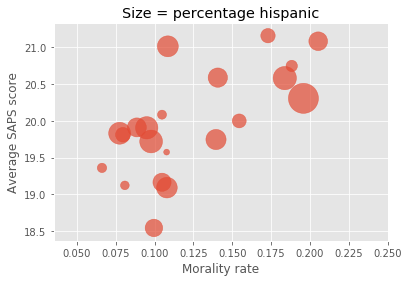

In [45]:
race = hisp
race_std = race.std() 
race_fl = race.mean() - race_std


# size_dots = num_ppl / max(num_ppl) * 1000
size_dots = (race - race_fl) * 40000
plt.scatter(mortality, saps, s=size_dots, alpha=0.7)
plt.title('Size = percentage hispanic')
plt.xlabel('Morality rate')
plt.ylabel('Average SAPS score')
plt.show()

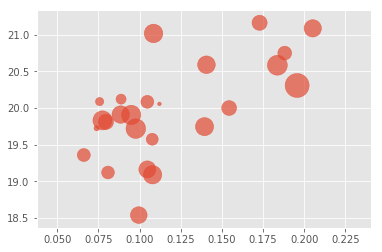

In [ ]:
# findings (above): gr48 (Septicemia) has more hispanics, which die more, but is also predicted better

In [293]:
### which diagnoses are more fatal?
N = 25

icd_gr = big.groupby('icd_gr').agg({'mort_icu': 'mean', 'subject_id': len}).copy()
# icd_gr['gr_name'] = pd.Series(icd_gr.index).apply(lambda x: group_d.get(x, None))

sort_icd = icd_gr.sort_values('subject_id', ascending=False)
top_icd_count = set(sort_icd.index[:10])

sort_mort = icd_gr.sort_values('mort_icu', ascending=False)
top_mort = set(sort_mort.index[:10])

big['in_top_icd'] = big.icd_gr.apply(lambda x: x in top_icd_count)
big['in_top_mort'] = big.icd_gr.apply(lambda x: x in top_mort)

df_agg = big.groupby(['ethnicity']).agg({'in_top_icd': 'mean', 'in_top_mort': 'mean'})

df_agg

,in_top_icd,in_top_mort
ethnicity,,
asian,0.391586,0.087379
black,0.394033,0.089500
hispanic,0.351873,0.095346
other,0.366547,0.089908
white,0.381223,0.090219


In [270]:
np.std([0.39, 0.39, 0.35, 0.366, 0.38])

0.01536749816983885